In [2]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# üîπ Cargar los datos
df_eth = pd.read_csv("Database/eth_final.csv")

# üîπ Convertir fechas a datetime
df_eth['Date'] = pd.to_datetime(df_eth['Date'])

# üîπ Imputaci√≥n de valores faltantes
tech_indicators = ['ETH_EMA_20', 'ETH_RSI', 'ETH_MACD']  # Eliminamos BTC_SMA_50

# Obtener los primeros dos meses de datos
start_date = df_eth['Date'].min()
end_date = start_date + pd.DateOffset(months=2)
df_initial = df_eth[(df_eth['Date'] >= start_date) & (df_eth['Date'] < end_date)]

# Rellenar indicadores t√©cnicos con el promedio de los primeros dos meses
for col in tech_indicators:
    mean_value = df_initial[col].mean()
    df_eth.loc[:, col] = df_eth[col].fillna(mean_value)

# Rellenar Fear_Greed_Index con el promedio entre el valor anterior y el siguiente
df_eth.loc[:, 'Fear_Greed_Index'] = df_eth['Fear_Greed_Index'].interpolate(method='linear')

# üîπ Eliminar variables redundantes
#df_btc.drop(columns=['BTC_SMA_50', 'BTC_Price_CryptoCompare', 'Open', 'High', 'Low'], inplace=True, errors='ignore')

# üîπ Eliminar variables redundantes
df_eth.drop(columns=['BTC_SMA_50', 'Volume','BTC_Price_CryptoCompare', 'Open', 'High', 'Low', 'BTC_Trends'], inplace=True, errors='ignore') # 'BTC_Sentiment'

# üîπ Normalizar los datos
scaler = MinMaxScaler()
df_scaled = df_eth.copy()
df_scaled[df_eth.columns.difference(['Date'])] = scaler.fit_transform(df_eth[df_eth.columns.difference(['Date'])])

# üîπ Mover la columna "Close" al final
df_scaled = df_scaled[[col for col in df_scaled.columns if col != "Close"] + ["Close"]]
# üîπ Eliminar la columna de fechas antes de guardar
df_scaled = df_scaled.drop(columns=['Date'], errors='ignore')

# üîπ Guardar datasets preprocesados
np.save("Dataset/df_scaled_eth.npy", df_scaled.values)
print("‚úÖ Datos preprocesados guardados en Dataset/")

2025-03-16 21:12:14.078909: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


‚úÖ Datos preprocesados guardados en Dataset/


#### Crear secuencias de tiempo (Seleccion aleatorea)

In [3]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# üîπ Cargar los datos normalizados
df_scaled = np.load("Dataset/df_scaled_eth.npy", allow_pickle=True)

# üîπ Crear secuencias para LSTM
sequence_length = 60  # 60 d√≠as de ventana
def create_sequences(data, target_index, sequence_length):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i : i + sequence_length, :-1])  # Features
        targets.append(data[i + sequence_length, target_index])  # Target
    return np.array(sequences), np.array(targets)

# Definir la posici√≥n de la variable objetivo (√∫ltima columna en df_scaled)
target_index = -1  # √öltima columna (precio futuro)

X, Y = create_sequences(df_scaled, target_index, sequence_length)

# üîπ Dividir en Train/Test
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = Y[:train_size], Y[train_size:]

# üîπ Guardar datasets para evitar desorden
np.save("Dataset/X_train_eth.npy", X_train)
np.save("Dataset/X_test_eth.npy", X_test)
np.save("Dataset/y_train_eth.npy", y_train)
np.save("Dataset/y_test_eth.npy", y_test)
print("‚úÖ Datasets para LSTM guardados en Dataset/")

‚úÖ Datasets para LSTM guardados en Dataset/


#### definir y entrenar el modelo Bi-LSTM

In [5]:
import pandas as pd
# üîπ Cargar los datos
df_eth = pd.read_csv("Database/eth_final.csv")

Epoch 1/100


/opt/conda/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 23s 380ms/step - loss: 5.4952 - val_loss: 2.1347
Epoch 2/100
46/46 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 17s 365ms/step - loss: 1.5935 - val_loss: 0.5398
Epoch 3/100
46/46 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 17s 368ms/step - loss: 0.3908 - val_loss: 0.1290
Epoch 4/100
46/46 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 17s 369ms/step - loss: 0.0886 - val_loss: 0.0341
Epoch 5/100
46/46 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 17s 366ms/step - loss: 0.0247 - val_loss: 0.0202
Epoch 6/100
46/46 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 17s 371ms/step - loss: 0.0152 - val_loss: 0.0123
Epoch 7/100
46/46 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 17s 371ms/step - loss: 0.0093 - val_loss: 0.0076
Epoch 8/100
46/46 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 17s 371ms/step - loss: 0.0082 - val_l

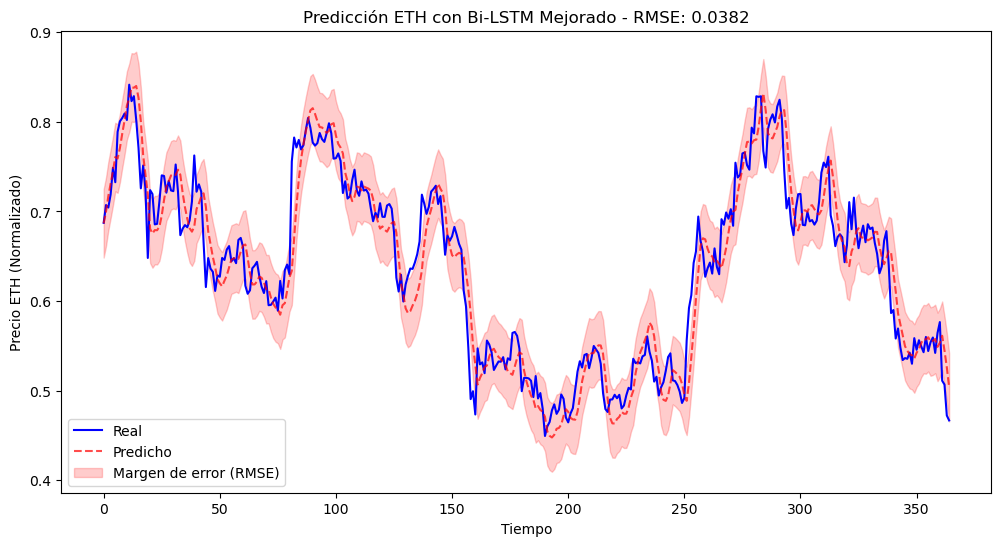

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

# üîπ Cargar los datos preprocesados
X_train = np.load("Dataset/X_train_eth.npy")
X_test = np.load("Dataset/X_test_eth.npy")
y_train = np.load("Dataset/y_train_eth.npy")
y_test = np.load("Dataset/y_test_eth.npy")

# üîπ Construcci√≥n del modelo Bi-LSTM mejorado
model_eth = Sequential([
    Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.005), activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]))),
    Dropout(0.15),
    Bidirectional(LSTM(256, return_sequences=False, kernel_regularizer=tf.keras.regularizers.l2(0.005), activation='tanh')),
    Dropout(0.15),
    Dense(128, activation='relu'),  # üîπ Nueva capa densa
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

# üîπ Compilar modelo con LR optimizado
model_eth.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

# üîπ Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# üîπ Entrenar el modelo
history = model_eth.fit(
    X_train, y_train,
    epochs=100,  
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

# üîπ Evaluaci√≥n del modelo
loss = model_eth.evaluate(X_test, y_test)
rmse = np.sqrt(loss)
print(f"üìâ RMSE del modelo ETH (mejorado): {rmse:.4f}")

# üîπ Obtener la Mediana Absoluta de Desviaciones (MAD) de ETH
eth_mad = np.median(np.abs(df_eth["Close"] - df_eth["Close"].median()))

# üîπ Convertir RMSE normalizado a d√≥lares usando MAD
rmse_dollars = rmse * eth_mad
print(f"üí∞ RMSE en d√≥lares (ETH, corregido): ${rmse_dollars:.2f}")

# üîπ Predicciones
y_pred = model_eth.predict(X_test)

# üîπ Gr√°fica mejorada de predicci√≥n vs. valores reales
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Real", color='blue')
plt.plot(y_pred, label="Predicho", linestyle="dashed", color='red', alpha=0.7)
plt.fill_between(range(len(y_test)), y_pred.flatten() - rmse, y_pred.flatten() + rmse, color='red', alpha=0.2, label="Margen de error (RMSE)")
plt.xlabel("Tiempo")
plt.ylabel("Precio ETH (Normalizado)")
plt.legend()
plt.title(f"Predicci√≥n ETH con Bi-LSTM Mejorado - RMSE: {rmse:.4f}")
plt.show()

In [7]:
# Guardar el modelo entrenado
model_eth.save("model_eth_Bi_LSTM.keras")
print("‚úÖ Modelo LSTM guardado en model_eth_Bi_LSTM.keras")

‚úÖ Modelo LSTM guardado en model_eth_Bi_LSTM.keras


12/12 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 129ms/step


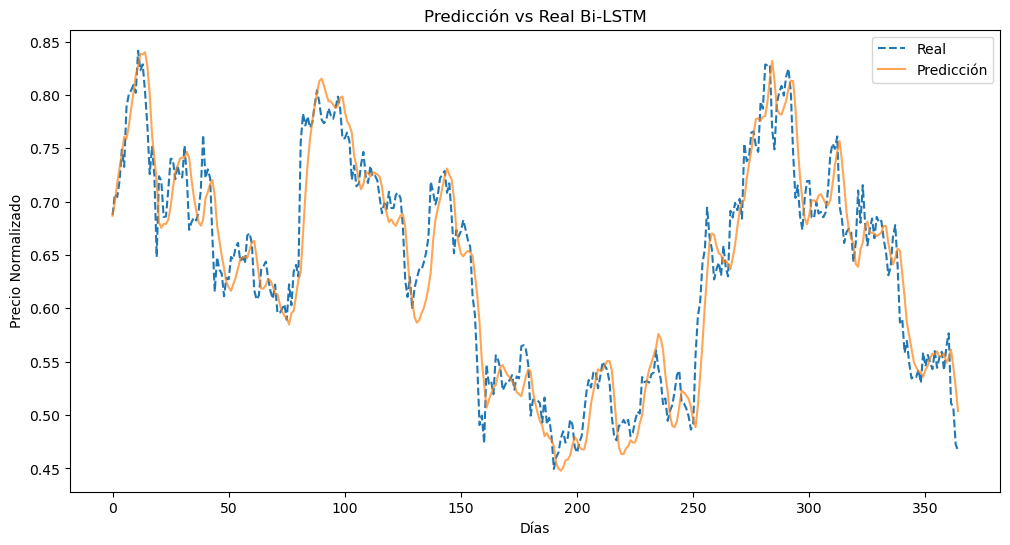

üí∞ RMSE en d√≥lares: $156.35
üìâ Error Cuadr√°tico Medio (MSE): 0.000953434603603554
üìâ Ra√≠z del Error Cuadr√°tico Medio (RMSE): 0.030877736374345092


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import load_model

# üîπ Cargar los datasets para evaluar el modelo
X_test = np.load("Dataset/X_test_eth.npy", allow_pickle=True)
y_test = np.load("Dataset/y_test_eth.npy", allow_pickle=True)

# üîπ Cargar el modelo entrenado
model = load_model("model_eth_Bi_LSTM.keras")

# üîπ Hacer predicciones
y_pred = model.predict(X_test)

# üîπ Desescalar los valores predichos y reales
y_test = y_test.reshape(-1, 1)
y_pred = y_pred.reshape(-1, 1)

# üîπ Visualizar las predicciones
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Real", linestyle='dashed')
plt.plot(y_pred, label="Predicci√≥n", alpha=0.7)
plt.legend()
plt.title("Predicci√≥n vs Real Bi-LSTM")
plt.xlabel("D√≠as")
plt.ylabel("Precio Normalizado")
plt.show()

# üîπ Evaluar el modelo
mse = np.mean((y_pred - y_test) ** 2)
rmse = np.sqrt(mse)

# üîπ Obtener la desviaci√≥n real del precio de BTC en el dataset
eth_price_std = np.std(y_pred) * 50000  # Ajustamos escala para convertirlo a USD
rmse_dollars = rmse * eth_price_std
print(f"üí∞ RMSE en d√≥lares: ${rmse_dollars:.2f}")
print(f"üìâ Error Cuadr√°tico Medio (MSE): {mse}")
print(f"üìâ Ra√≠z del Error Cuadr√°tico Medio (RMSE): {rmse}")